In [23]:
import wandb
from robust_detection import wandb_config
from robust_detection.data_utils.baselines_data_utils import ObjectsCountDataModule
from robust_detection.baselines.cnn_model import CNN
import pandas as pd
import pytorch_lightning as pl
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
#from robust_detection.baselines.detection_cnn import objects_detection_cnn

#import multiprocessing
#multiprocessing.set_start_method('fork')

In [24]:
gpu = 0
api = wandb.Api()

results = {}

#sweep_dict = {"m5fk2uh8":CNN}
sweep_dict = {"wps6fgrx":CNN}
model_names = ["CNN"]


#data_dict = {"MMSynthetic":SyntheticMMDataModule, "Pendulum":PendulumDataModule, "CV":CVDataModule}
#data_dict = {"molecules/mol_labels":ObjectsCountDataModule}#, "mnist/alldigits_2":MNISTCountDataModule,  "mnist/alldigits_5":MNISTCountDataModule} #, \
            #"mnist/alldigits_large":MNISTCountDataModule, "mnist/alldigits_2_large":MNISTCountDataModule,  "mnist/alldigits_5_large":MNISTCountDataModule,}
#data_dict = {"Pendulum":PendulumDataModule}
#data_dict = {"mnist/alldigits_20":ObjectsCountDataModule}
data_dict = {"clevr/clevr_all":ObjectsCountDataModule}
fold_name = "fold"
pre_trained = True

In [25]:
df = pd.DataFrame()

In [26]:
for i_mod, sweep_name in enumerate(sweep_dict.keys()):

    pd_dict = {"Model":model_names[i_mod] + " (MSE)"}
    pd_dict_acc = {"Model":model_names[i_mod] + " (Acc)"}

    model_cls = sweep_dict[sweep_name]
    sweep = api.sweep(f"{ENTITY}/object_detection/{sweep_name}")

    for ood in [False,True]:

        pd_dict["Type"] = "OOD" if ood else "In-distribution"
        pd_dict_acc["Type"] = "OOD" if ood else "In-distribution"
        
        for data_key in data_dict.keys():

            best_runs = []
            for fold in [0,1,2,3,4]:
                runs_fold = [r for r in sweep.runs if (r.config.get(fold_name)==fold) and (r.config.get("data_dir")==data_key) and (r.config.get("pre_trained")==pre_trained)]
                runs_fold_sorted = sorted(runs_fold,key = lambda run: run.summary.get("restored_val_loss"), reverse = False)
                best_runs.append(runs_fold_sorted[0])

In [27]:
run = best_runs[0]
fname = [f.name for f in run.files() if "ckpt" in f.name][0]
run.file(fname).download(replace = True, root = ".")
model = model_cls.load_from_checkpoint(fname)
os.remove(fname)

hparams = dict(model.hparams)

dataset = data_dict[data_key](**hparams)
dataset.prepare_data()
trainer = pl.Trainer(logger = False, gpus = 1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [28]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import tqdm

In [33]:
#functions definitions

import cv2

def find_threshold_number_islands(cam_,nobj):
    
    MAX_ITERATIONS = 25
    sigma = 0
    fixed_mean = 0.5
    thresh = fixed_mean
    
    best_thresh = (fixed_mean,0)
    
    #print(f"Threshold = :{thresh}")
    try:
        num_islands = get_number_islands(cam_,fixed_mean)
    except RecursionError:
        num_islands = 0
        
    iter_idx = 0
    while num_islands != nobj:
        if sigma<0.94:
            sigma += 0.05
        #thresh+=0.1
    
        thresh = fixed_mean + np.random.rand()*sigma - sigma/2
        try:
            num_islands = get_number_islands(cam_,thresh)
        except RecursionError:
            num_islands = num_islands
        #print("Num Islands")
        #print(num_islands)
        
        if np.abs(num_islands-nobj)< np.abs(best_thresh[1]-nobj):
            best_thresh = (thresh,num_islands)
        
        if iter_idx>MAX_ITERATIONS:
            break
            
        iter_idx += 1
                
    if num_islands == nobj:
        return thresh
    else:
        return best_thresh[0]

def get_boxes_from_contour(contours, img):
    
    boxes = []
    scores = []
    for item in range(len(contours)):
        cnt = contours[item]
        if len(cnt)>5:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours
            
            boxes.append(torch.Tensor([x,y,x+w,y+h]))
            
            scores.append(img[:,y:y+h,x:x+w].max())

        else: print("contour error (too small)")
    return boxes, scores

def get_number_islands(cam_array, threshold):
    graph = np.zeros_like(cam_array)
    graph[cam_array > threshold] = 1
    graph[cam_array <= threshold] = 0

    class Graph:

        def __init__(self, row, col, g):
            self.ROW = row
            self.COL = col
            self.graph = g

        # A function to check if a given cell
        # (row, col) can be included in DFS
        def isSafe(self, i, j, visited):
            # row number is in range, column number
            # is in range and value is 1
            # and not yet visited
            return (i >= 0 and i < self.ROW and
                    j >= 0 and j < self.COL and
                    not visited[i][j] and self.graph[i][j])


        # A utility function to do DFS for a 2D
        # boolean matrix. It only considers
        # the 8 neighbours as adjacent vertices
        def DFS(self, i, j, visited):

            # These arrays are used to get row and
            # column numbers of 8 neighbours
            # of a given cell
            rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1];
            colNbr = [-1,  0,  1, -1, 1, -1, 0, 1];

            # Mark this cell as visited
            visited[i][j] = True

            # Recur for all connected neighbours
            for k in range(8):
                if self.isSafe(i + rowNbr[k], j + colNbr[k], visited):
                    self.DFS(i + rowNbr[k], j + colNbr[k], visited)


        # The main function that returns
        # count of islands in a given boolean
        # 2D matrix
        def countIslands(self):
            # Make a bool array to mark visited cells.
            # Initially all cells are unvisited
            visited = [[False for j in range(self.COL)]for i in range(self.ROW)]

            # Initialize count as 0 and traverse
            # through the all cells of
            # given matrix
            count = 0
            for i in range(self.ROW):
                for j in range(self.COL):
                    # If a cell with value 1 is not visited yet,
                    # then new island found
                    if visited[i][j] == False and self.graph[i][j] == 1:
                        # Visit all cells in this island
                        # and increment island count
                        self.DFS(i, j, visited)
                        count += 1

            return count

    row = len(graph)
    col = len(graph[0])

    g = Graph(row, col, graph)

    return(g.countIslands())


def get_boxes_single_image(X,y_pred,cam,n_classes = 10):
    """
    cam is the class activation map for all classes
    """
    boxes_img = []
    labels_img = []
    scores_img = []
    for class_i in range(n_classes):
        #print(class_i)
        
        #targets = [ClassifierOutputTarget(class_i)]
        #cam_ = cam(input_tensor=X[None,...], targets=targets)
        cam_ = cam[class_i]
        nobj_pred = y_pred.round()[class_i].detach().long().numpy()

        if nobj_pred>0:
            
            #plt.figure()
            #plt.imshow(cam_[0][...,None])
            #plt.show()
            
            thresh = find_threshold_number_islands(cam_[0],nobj_pred)
            cam_thresh = np.zeros_like(cam_)
            cam_thresh[cam_>thresh]=255
            

            contours,hierarchy = cv2.findContours(cam_thresh[0].astype(np.uint8), 1, 2)

            bbox_coords, scores = get_boxes_from_contour(contours, img = cam_)#, img = cam_thresh.astype(np.uint8))
            boxes_img += bbox_coords
            labels_img += [class_i]*len(bbox_coords)
            scores_img += scores
            
    return torch.stack(boxes_img), labels_img, scores_img

def f(i,X,y_pred,cam_dict,n_classes):
    boxes, labels, scores = get_boxes_single_image(X[i].cpu(),y_pred[i].cpu(),cam = [cam_dict[class_i][i][None,...] for class_i in range(n_classes)], n_classes = n_classes)
    return(boxes,labels, scores)
    
def get_cnn_boxes(X,y_pred,cam,n_classes= 10):
    #boxes_list = []
    #labels_list = []
    #scores_list = []
    
    print("Computing CAM...")
    cam_dict = {class_i:cam(input_tensor=X, targets=[ClassifierOutputTarget(class_i)]*len(X)) for class_i in range(n_classes)}
    print("Done")
    
    print("Computing boxes...")
    
    
    X = X.detach().cpu()
    y_pred = y_pred.detach().cpu()

    from multiprocessing import Pool
        
    with Pool(10) as p:
        res = p.starmap(f,zip([i for i in range(len(X))],[X for _ in range(len(X))],[y_pred for _ in range(len(X))],[cam_dict for _ in range(len(X))],[n_classes for _ in range(len(X))]))
        
    boxes_list = [b[0] for b in res]
    labels_list = [b[1] for b in res]
    scores_list = [b[2] for b in res]

    #for i in range(len(X)):
    #    boxes, labels, scores = get_boxes_single_image(X[i].cpu(),y_pred[i].cpu(),cam = [cam_dict[class_i][i][None,...] for class_i in range(n_classes)], n_classes = n_classes)
    #    boxes_list.append(boxes)
    #    labels_list.append(labels)
    #    scores_list.append(scores)
    return boxes_list, labels_list, scores_list


def objects_detection_cnn(model,dataloader):

    target_layers = [model.model[1].layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    boxes_list = []
    labels_list = []
    scores_list = []
    for i,batch in tqdm.tqdm(enumerate(dataloader)):
        print(i)
        X,y = batch
        y_pred = model(X.to(model.device))

        boxes, labels, scores = get_cnn_boxes(X.to(model.device),y_pred,n_classes = y_pred.shape[1], cam = cam)

        boxes_list.append(boxes)
        labels_list.append(labels)
        scores_list.append(scores)

    return boxes_list, labels_list, scores_list

In [30]:
target_layers = [model.model[1].layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

for i,batch in tqdm.tqdm(enumerate(dataset.val_dataloader())):
    X,y, targets = batch
    y_pred = model(X.to(model.device))
    acc = model.compute_accuracy(y.to(model.device),y_pred,torch.ones_like(y_pred))
    print(acc)
    
    #grayscale_cam = cam(input_tensor=X, targets=targets * len(X))
    #nobj_pred = y_pred.round()[:,idx]
    
    boxes, labels, scores = get_cnn_boxes(X.to(model.device),y_pred,n_classes = y_pred.shape[1], cam = cam)
    
    break

0it [00:00, ?it/s]

tensor(1., device='cuda:0')
Computing CAM...
Done
Computing boxes...
contour error (too small)


0it [00:41, ?it/s]


In [10]:
len(boxes)

32

tensor([[219., 269., 235., 285.],
        [112., 162.,  88., 138.],
        [192., 242.,  78., 128.],
        [155., 205., 178., 228.],
        [311., 361., 140., 190.]])

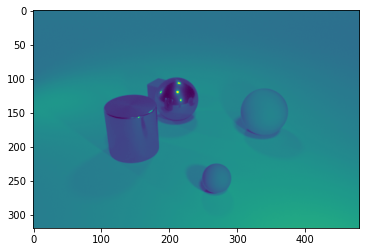

In [31]:
plt.imshow(X[1].permute(1,2,0))

In [20]:
img_with_true_boxes.shape

torch.Size([3, 320, 480])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


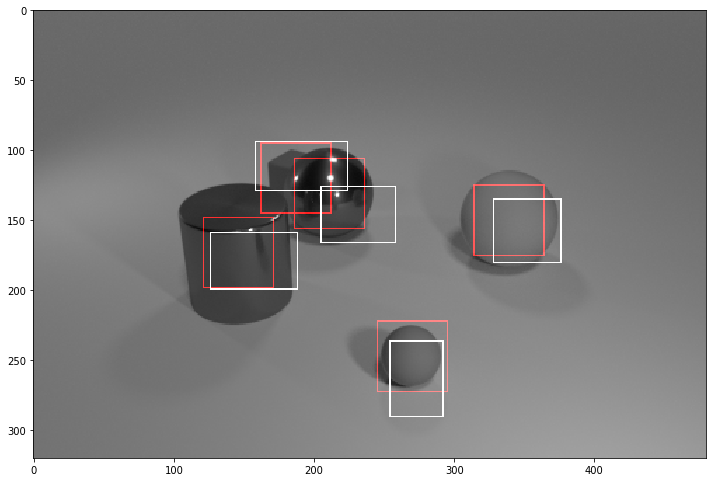

In [32]:
import torchvision
img_idx = 1
img_with_boxes = torchvision.utils.draw_bounding_boxes(torch.Tensor(X[img_idx]).permute(1,2,0).to(torch.uint8).permute(2,0,1),boxes[img_idx])
img_with_true_boxes = torchvision.utils.draw_bounding_boxes(torch.Tensor(X[img_idx]).permute(1,2,0).to(torch.uint8).permute(2,0,1),targets[img_idx]["boxes"], colors = "red")



fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(X[img_idx].permute(1,2,0) + img_with_boxes.permute(1,2,0).numpy() + img_with_true_boxes.permute(1,2,0).numpy(), interpolation='nearest')
plt.tight_layout()

In [29]:
import cv2

def find_threshold_number_islands(cam_,nobj):
    
    MAX_ITERATIONS = 25
    sigma = 0
    fixed_mean = 0.5
    thresh = fixed_mean
    
    best_thresh = (fixed_mean,0)
    
    #print(f"Threshold = :{thresh}")
    try:
        num_islands = get_number_islands(cam_,fixed_mean)
    except RecursionError:
        num_islands = 0
        
    iter_idx = 0
    while num_islands != nobj:
        if sigma<0.94:
            sigma += 0.05
        #thresh+=0.1
    
        thresh = fixed_mean + np.random.rand()*sigma - sigma/2
        try:
            num_islands = get_number_islands(cam_,thresh)
        except RecursionError:
            num_islands = num_islands
        #print("Num Islands")
        #print(num_islands)
        
        if np.abs(num_islands-nobj)< np.abs(best_thresh[1]-nobj):
            best_thresh = (thresh,num_islands)
        
        if iter_idx>MAX_ITERATIONS:
            break
            
        iter_idx += 1
                
    if num_islands == nobj:
        return thresh
    else:
        return best_thresh[0]

def get_boxes_from_contour(contours, img):
    
    boxes = []
    scores = []
    for item in range(len(contours)):
        cnt = contours[item]
        if len(cnt)>5:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours
            
            boxes.append(torch.Tensor([x,y,x+w,y+h]))
            
            scores.append(img[:,y:y+h,x:x+w].max())

        else: print("contour error (too small)")
    return boxes, scores

def get_number_islands(cam_array, threshold):
    graph = np.zeros_like(cam_array)
    graph[cam_array > threshold] = 1
    graph[cam_array <= threshold] = 0

    class Graph:

        def __init__(self, row, col, g):
            self.ROW = row
            self.COL = col
            self.graph = g

        # A function to check if a given cell
        # (row, col) can be included in DFS
        def isSafe(self, i, j, visited):
            # row number is in range, column number
            # is in range and value is 1
            # and not yet visited
            return (i >= 0 and i < self.ROW and
                    j >= 0 and j < self.COL and
                    not visited[i][j] and self.graph[i][j])


        # A utility function to do DFS for a 2D
        # boolean matrix. It only considers
        # the 8 neighbours as adjacent vertices
        def DFS(self, i, j, visited):

            # These arrays are used to get row and
            # column numbers of 8 neighbours
            # of a given cell
            rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1];
            colNbr = [-1,  0,  1, -1, 1, -1, 0, 1];

            # Mark this cell as visited
            visited[i][j] = True

            # Recur for all connected neighbours
            for k in range(8):
                if self.isSafe(i + rowNbr[k], j + colNbr[k], visited):
                    self.DFS(i + rowNbr[k], j + colNbr[k], visited)


        # The main function that returns
        # count of islands in a given boolean
        # 2D matrix
        def countIslands(self):
            # Make a bool array to mark visited cells.
            # Initially all cells are unvisited
            visited = [[False for j in range(self.COL)]for i in range(self.ROW)]

            # Initialize count as 0 and traverse
            # through the all cells of
            # given matrix
            count = 0
            for i in range(self.ROW):
                for j in range(self.COL):
                    # If a cell with value 1 is not visited yet,
                    # then new island found
                    if visited[i][j] == False and self.graph[i][j] == 1:
                        # Visit all cells in this island
                        # and increment island count
                        self.DFS(i, j, visited)
                        count += 1

            return count

    row = len(graph)
    col = len(graph[0])

    g = Graph(row, col, graph)

    return(g.countIslands())


def get_boxes_single_image(X,y_pred,cam,n_classes = 10):
    """
    cam is the class activation map for all classes
    """
    boxes_img = []
    labels_img = []
    scores_img = []
    for class_i in range(n_classes):
        #print(class_i)
        
        #targets = [ClassifierOutputTarget(class_i)]
        #cam_ = cam(input_tensor=X[None,...], targets=targets)
        cam_ = cam[class_i]
        nobj_pred = y_pred.round()[class_i].detach().long().numpy()

        if nobj_pred>0:
            
            #plt.figure()
            #plt.imshow(cam_[0][...,None])
            #plt.show()
            
            thresh = find_threshold_number_islands(cam_[0],nobj_pred)
            cam_thresh = np.zeros_like(cam_)
            cam_thresh[cam_>thresh]=255
            

            contours,hierarchy = cv2.findContours(cam_thresh[0].astype(np.uint8), 1, 2)

            bbox_coords, scores = get_boxes_from_contour(contours, img = cam_)#, img = cam_thresh.astype(np.uint8))
            boxes_img += bbox_coords
            labels_img += [class_i]*len(bbox_coords)
            scores_img += scores
            
    return torch.stack(boxes_img), labels_img, scores_img

def f(i,X,y_pred,cam_dict,n_classes):
    boxes, labels, scores = get_boxes_single_image(X[i].cpu(),y_pred[i].cpu(),cam = [cam_dict[class_i][i][None,...] for class_i in range(n_classes)], n_classes = n_classes)
    return(boxes,labels, scores)
    
def get_cnn_boxes(X,y_pred,cam,n_classes= 10):
    #boxes_list = []
    #labels_list = []
    #scores_list = []
    
    print("Computing CAM...")
    cam_dict = {class_i:cam(input_tensor=X, targets=[ClassifierOutputTarget(class_i)]*len(X)) for class_i in range(n_classes)}
    print("Done")
    
    print("Computing boxes...")
    
    
    X = X.detach().cpu()
    y_pred = y_pred.detach().cpu()

    from multiprocessing import Pool
        
    with Pool(10) as p:
        res = p.starmap(f,zip([i for i in range(len(X))],[X for _ in range(len(X))],[y_pred for _ in range(len(X))],[cam_dict for _ in range(len(X))],[n_classes for _ in range(len(X))]))
        
    boxes_list = [b[0] for b in res]
    labels_list = [b[1] for b in res]
    scores_list = [b[2] for b in res]

    #for i in range(len(X)):
    #    boxes, labels, scores = get_boxes_single_image(X[i].cpu(),y_pred[i].cpu(),cam = [cam_dict[class_i][i][None,...] for class_i in range(n_classes)], n_classes = n_classes)
    #    boxes_list.append(boxes)
    #    labels_list.append(labels)
    #    scores_list.append(scores)
    return boxes_list, labels_list, scores_list


def objects_detection_cnn(model,dataloader):

    target_layers = [model.model[1].layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    boxes_list = []
    labels_list = []
    scores_list = []
    for i,batch in tqdm.tqdm(enumerate(dataloader)):
        print(i)
        X,y = batch
        y_pred = model(X.to(model.device))

        boxes, labels, scores = get_cnn_boxes(X.to(model.device),y_pred,n_classes = y_pred.shape[1], cam = cam)

        boxes_list.append(boxes)
        labels_list.append(labels)
        scores_list.append(scores)

    return boxes_list, labels_list, scores_list

In [288]:
def get_cnn_boxes(X,y_pred,cam, n_classes = 10,):
    boxes = []
    labels = []
    scores = []
    for i_img, cam_ in enumerate(cam):
        #rgb_img = X[i_img].permute(1,2,0).numpy()
        boxes_img = []
        labels_img = []
        scores_img = []
        print(i_img)
        for class_i in range(n_classes):
            print(class_i)
            targets = [ClassifierOutputTarget(class_i)] 
            cam_ = cam(input_tensor=X[i_img][None,...], targets=targets)
            nobj_pred = y_pred.round()[:,class_i]
            
            if nobj_pred[i_img]>0:

                thresh = find_threshold_number_islands(cam_,nobj_pred[i_img])
                cam_thresh = np.zeros_like(cam_)
                cam_thresh[cam_>thresh]=255

                contours,hierarchy = cv2.findContours(cam_thresh.astype(np.uint8), 1, 2)

                bbox_coords = get_boxes_from_contour(contours)
                boxes_img += bbox_coords
                labels_img += [class_i]*len(boxes_img)
        
        boxes.append(torch.stack(boxes_img))
        labels.append(torch.Tensor(labels_img))
        scores.append(torch.Tensor(scores_img))
    
    return boxes, labels, scores

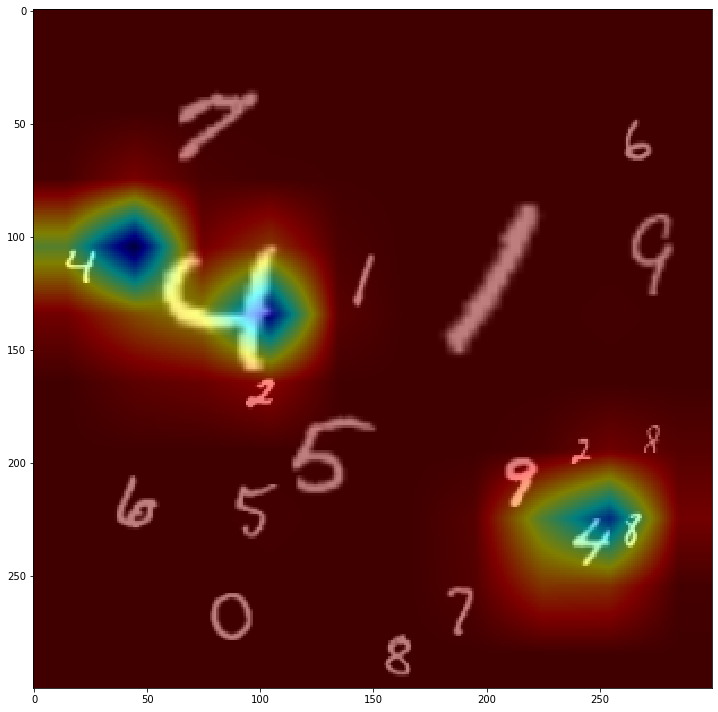

In [196]:
img_idx = 0
cam_ = grayscale_cam[img_idx, :]
rgb_img = X[img_idx,:].permute(1,2,0).numpy()
visualization = show_cam_on_image(rgb_img, cam_, use_rgb=False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(visualization, interpolation='nearest')
plt.tight_layout()

In [13]:
#threshold = 0.5
#get_number_islands(cam_,threshold)

def find_threshold_number_islands(cam_,nobj):
    sigma = 0
    fixed_mean = 0.5
    thresh = fixed_mean
    num_islands = get_number_islands(cam_,fixed_mean)
    while num_islands != nobj:
        if sigma<0.99:
            sigma += 0.01
        thresh = fixed_mean + np.random.rand()*sigma - sigma/2
        num_islands = get_number_islands(cam_,thresh)
        print("Num Islands")
        print(num_islands)
    return thresh

thresh = find_threshold_number_islands(cam_,nobj_pred[img_idx])
cam_thresh = np.zeros_like(cam_)
cam_thresh[cam_>thresh]=255
print(thresh)

NameError: name 'cam_' is not defined

In [14]:
import cv2

contours,hierarchy = cv2.findContours(cam_thresh.astype(np.uint8), 1, 2)

NameError: name 'cam_thresh' is not defined

In [279]:
torch.stack(bbox_coords)

tensor([[228., 212., 268., 240.],
        [ 82., 117., 119., 151.],
        [ 17.,  88.,  62., 126.]])

In [15]:
from PIL import Image

contours,hierarchy = cv2.findContours(cam_thresh.astype(np.uint8), 1, 2)

def get_boxes_from_contour(contours, img = cam_thresh.astype(np.uint8)):
    
    boxes = []
    for item in range(len(contours)):
        cnt = contours[item]
        if len(cnt)>20:
            #print(len(cnt))
            x,y,w,h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
            poly_coords = [cnt] # polygon coordinates are based on contours

            #x = int(x*self.scale_list[0]) # rescaling the boundary box based on user input
            #y = int(y*self.scale_list[1])
            #w = int(w*self.scale_list[2])
            #h = int(h*self.scale_list[3])

            boxes.append(torch.Tensor([x,y,x+w,y+h]))

        else: print("contour error (too small)")
    return boxes
            
bbox_coords = get_boxes_from_contour(contours)

NameError: name 'cam_thresh' is not defined

In [275]:
img_with_boxes.shape

torch.Size([3, 300, 300])

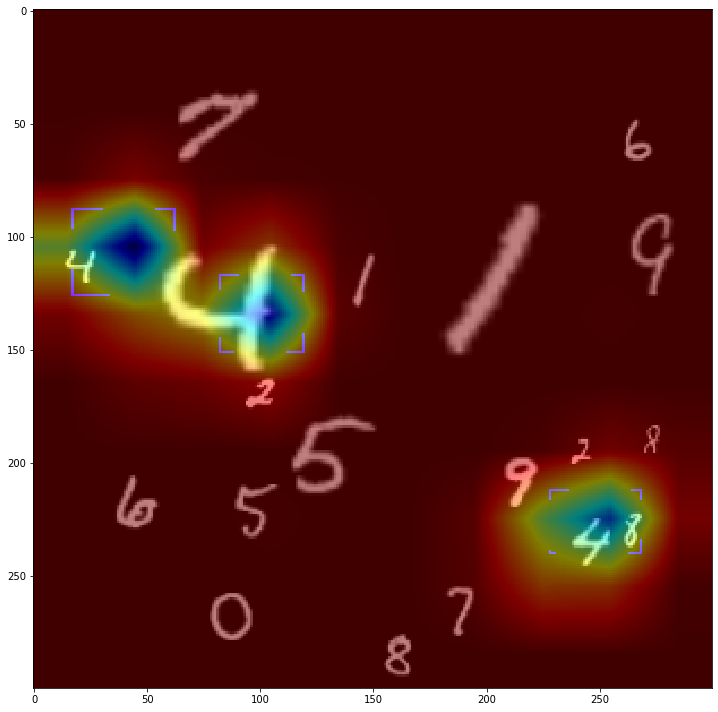

In [273]:
import torchvision
img_with_boxes = torchvision.utils.draw_bounding_boxes(torch.Tensor(rgb_img).to(torch.uint8).permute(2,0,1),torch.stack(bbox_coords))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(visualization+img_with_boxes.permute(1,2,0).numpy(), interpolation='nearest')
plt.tight_layout()

In [267]:
rgb_img.shape

(300, 300, 1)

[228, 212, 268, 240]

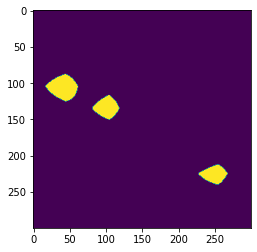

In [252]:
plt.imshow(img)
bbox_coords

In [226]:
cam_thresh

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [219]:
cam_.dtype

dtype('float32')

In [283]:
def get_number_islands(cam_array, threshold):
    graph = np.zeros_like(cam_array)
    graph[cam_array > threshold] = 1
    graph[cam_array <= threshold] = 0

    class Graph:

        def __init__(self, row, col, g):
            self.ROW = row
            self.COL = col
            self.graph = g

        # A function to check if a given cell
        # (row, col) can be included in DFS
        def isSafe(self, i, j, visited):
            # row number is in range, column number
            # is in range and value is 1
            # and not yet visited
            return (i >= 0 and i < self.ROW and
                    j >= 0 and j < self.COL and
                    not visited[i][j] and self.graph[i][j])


        # A utility function to do DFS for a 2D
        # boolean matrix. It only considers
        # the 8 neighbours as adjacent vertices
        def DFS(self, i, j, visited):

            # These arrays are used to get row and
            # column numbers of 8 neighbours
            # of a given cell
            rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1];
            colNbr = [-1,  0,  1, -1, 1, -1, 0, 1];

            # Mark this cell as visited
            visited[i][j] = True

            # Recur for all connected neighbours
            for k in range(8):
                if self.isSafe(i + rowNbr[k], j + colNbr[k], visited):
                    self.DFS(i + rowNbr[k], j + colNbr[k], visited)


        # The main function that returns
        # count of islands in a given boolean
        # 2D matrix
        def countIslands(self):
            # Make a bool array to mark visited cells.
            # Initially all cells are unvisited
            visited = [[False for j in range(self.COL)]for i in range(self.ROW)]

            # Initialize count as 0 and traverse
            # through the all cells of
            # given matrix
            count = 0
            for i in range(self.ROW):
                for j in range(self.COL):
                    # If a cell with value 1 is not visited yet,
                    # then new island found
                    if visited[i][j] == False and self.graph[i][j] == 1:
                        # Visit all cells in this island
                        # and increment island count
                        self.DFS(i, j, visited)
                        count += 1

            return count

    row = len(graph)
    col = len(graph[0])

    g = Graph(row, col, graph)

    return(g.countIslands())

In [35]:
cam.pool_features.shape

torch.Size([1, 512, 1, 1])

In [37]:
model.model[1].fc(cam.pool_features[...,0].permute(0,2,1)).shape

torch.Size([1, 1, 10])

In [30]:
model.model[1]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model.model[1].layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [29]:
print(df.loc[df.Model.str.contains("Acc")].to_latex(escape = False,index= False))

\begin{tabular}{lll}
\toprule
    Model &            Type & mnist/alldigits_20 \\
\midrule
CNN (Acc) & In-distribution &  $ 0.697\pm0.121 $ \\
CNN (Acc) &             OOD &  $ 0.673\pm0.137 $ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2445726/3650743742.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.loc[df.Model.str.contains("Acc")].to_latex(escape = False,index= False))


In [15]:
sweep_dict

{'4avttlwb': robust_detection.baselines.cnn_model.CNN}